In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.signal import butter,filtfilt
from scipy.interpolate import interp1d

In [2]:
# import activity analysis functions from aa.py file in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport aa

In [3]:
import scipy.io
mat = scipy.io.loadmat('data/stim4.mat')

In [4]:
def extract(tree):
    for x in range(len(tree)):
        if type(tree[x]) == list:
            tree[x] = extract(tree[x])
        else:
            return tree[x]

    return tree

In [5]:
len(mat['stim'][0][0]) #11


11

In [6]:
mat['stim'][0][0][0] # stimulus details
mat['stim'][0][0][1] # listening dates and times
mat['stim'][0][0][2] # time
mat['stim'][0][0][3] # corrugator sEMG
mat['stim'][0][0][4] # zygomaticus sEMG
mat['stim'][0][0][5] # trapezius sEMG
mat['stim'][0][0][6] # BVP
mat['stim'][0][0][7] # SCR
mat['stim'][0][0][8] # temp
mat['stim'][0][0][9] # Resp
mat['stim'][0][0][10] # Ratings
stim = mat['stim'][0][0]
arrayRef =[stim[1][0][0][0][0][1].dtype,stim[1][0][0][0][0][15].dtype]
print(stim[0])
print(stim[0][0][0][1][0])

Levels =(['track', 'sess', 'time', 'emgc', 'emgz', 'emgt', 'bvp', 'scon', 'temp', 'resp', 'beh'])
Level = [['piece', 'album', 'performer', 'composer', 'genre', 'stimN', 'duration']]
Level.append(['date', 'timeD', 'timeS', 'order', 'prev', 'notes', 'sneezes'])
Level.append(['s', 'sT', 'Hz'])
Level.append(['raw', 'filt', 'filtN', 'rms', 'rmsN'])
Level.append(['raw', 'filt', 'filtN', 'rms', 'rmsN'])
Level.append(['raw', 'filt', 'filtN', 'rms', 'rmsN'])
Level.append(['raw', 'filt', 'filtN', 'bpm', 'amp', 'beat'])
Level.append(['raw', 'filt', 'filtN', 'tonic', 'tonicN', 'ORt'])
Level.append(['raw', 'rawN', 'filt', 'filtN'])
Level.append(['raw', 'rawN', 'filt', 'filtN', 'bpm', 'phase', 'Inha'])
Level.append(['aro', 'val'])

LevelResponse = ['D', 'T', 'R', 'N']
Level

[[(array(['The Littlest Birds'], dtype='<U18'), array(['Blue Horse'], dtype='<U10'), array(['The Be Good Tanyas'], dtype='<U18'), array(['The Be Good Tanyas'], dtype='<U18'), array(['Folk'], dtype='<U4'), array([[4]], dtype=uint8), array([[246]], dtype=uint8))]]
Blue Horse


[['piece', 'album', 'performer', 'composer', 'genre', 'stimN', 'duration'],
 ['date', 'timeD', 'timeS', 'order', 'prev', 'notes', 'sneezes'],
 ['s', 'sT', 'Hz'],
 ['raw', 'filt', 'filtN', 'rms', 'rmsN'],
 ['raw', 'filt', 'filtN', 'rms', 'rmsN'],
 ['raw', 'filt', 'filtN', 'rms', 'rmsN'],
 ['raw', 'filt', 'filtN', 'bpm', 'amp', 'beat'],
 ['raw', 'filt', 'filtN', 'tonic', 'tonicN', 'ORt'],
 ['raw', 'rawN', 'filt', 'filtN'],
 ['raw', 'rawN', 'filt', 'filtN', 'bpm', 'phase', 'Inha'],
 ['aro', 'val']]

In [7]:
SRP ={}

md = 0
bit = {}
structNames = Level[md] 
for i in range(len(structNames)):
    det =stim[0][0][md][i].ravel()[0] #extract(stim[0][0][md][i])
    
    bit[structNames[i]] = det
SRP[Levels[md]]=bit

md +=1
bit = {}
structNames = Level[md] 
for i in range(len(structNames)):
    det =  stim[md][0][0][i].ravel()
    if len(det)==24:
        days = []
        for j in range(24):
            if str(det[j].dtype).startswith('<U'):
                if len(extract([det[j]]))>0:
                    days.append(extract(det[j]))
                else:
                    days.append([])
            else:
                if str(det[j].dtype).startswith('u'):
                    if det[j].shape == (0,0):
                        days.append('')
                    else:
                        days.append(det[j])
                    
                else:
                    days.append(det[j])
        det = days
    bit[structNames[i]] = det
SRP[Levels[md]]=bit    

md +=1
bit = {}
structNames = Level[md] 
for i in range(len(structNames)):
    det =stim[md][0][0][i].ravel()
    if len(det)==1:
        det = det[0]
    bit[structNames[i]] = det
SRP[Levels[md]]=bit
SRP['time']['s'] = np.round(SRP['time']['s'],2)

for md in range(3,11):
    bit = {}
    structNames = Level[md] 
    for i in range(len(structNames)):
        det =  stim[md][0][0][i].ravel()[0]
        if len(det)==4:
            signals = {LevelResponse[0]:pd.DataFrame(data=det[0],index=SRP['time']['s']),
                      LevelResponse[1]:det[1][0],
                      LevelResponse[2]:det[2][0][0],
                      LevelResponse[3]:det[3][0]}
            bit[structNames[i]] = signals
    SRP[Levels[md]]=bit  


In [8]:
SRP.keys()

dict_keys(['track', 'sess', 'time', 'emgc', 'emgz', 'emgt', 'bvp', 'scon', 'temp', 'resp', 'beh'])

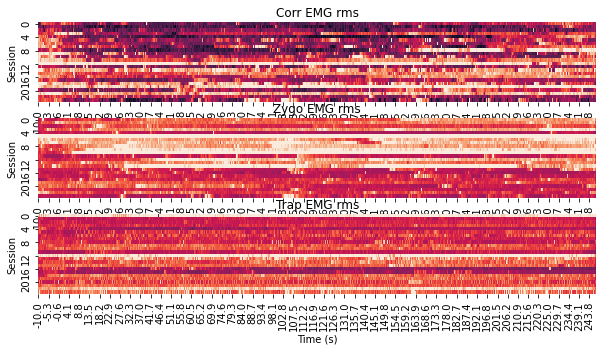

In [9]:
bio = SRP['emgc']['rms']
kstep = 10
substep = np.arange(0,len(bio['D']),kstep)
Np = 24

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(311)
bio = SRP['emgc']['rms']
bio['D']
sns.heatmap(bio['D'].iloc[substep].transpose(),ax=ax,cbar=False, vmin=0, vmax=4)#, cmap="YlGnBu")
plt.title(bio['T'])
plt.ylabel('Session')

ax = fig.add_subplot(312)
bio = SRP['emgz']['rms']
sns.heatmap(bio['D'].iloc[substep].transpose(),ax=ax,cbar=False,vmin=0, vmax=4)#, cmap="YlGnBu")
plt.title(bio['T'])
plt.ylabel('Session')

ax = fig.add_subplot(313)
bio = SRP['emgt']['rms']
sns.heatmap(bio['D'].iloc[substep].transpose(),ax=ax,cbar=False,vmin=0, vmax=8)#, cmap="YlGnBu")
plt.title(bio['T'])
plt.ylabel('Session')
plt.xlabel('Time (s)')
plt.show()


<AxesSubplot:>

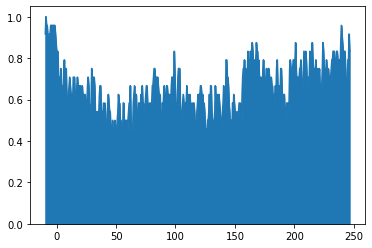

In [19]:
actType='UBound'
Thresh = 2
AC = activityCount(Data,FrameSize,HopSize,Thresh,actType)
AC['Total'].plot.area()

<AxesSubplot:>

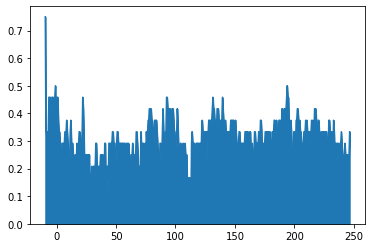

In [15]:
actType='LBound'
Thresh = 2
AC = aa.activityCount(Data,FrameSize,HopSize,Thresh,actType)
AC['Total'].plot.area()

In [348]:
AC

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,Total
-9.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-8.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
Data = SRP['emgc']['rms']['D']
FrameSize = 1 # second
HopSize = 0.5 # seconds
Thresh = 4

Time = Data.index
cols = Data.columns
newTime = np.arange(FrameSize/2+Time[0],Time[-1],HopSize)
Acts = pd.DataFrame(columns = cols)
# ""Acts['Time']=newTime
# Acts=Acts.set_index('Time')""

tic = time.time()
for i in range(len(newTime)):
        t = newTime[i]
        frame = Data.loc[t-(FrameSize*0.5):t+(FrameSize*0.5),:].copy()
        UB = frame.max(0)
        UB[UB>=Thresh] = Thresh
        UB[UB<Thresh] = 0
        UB[UB==Thresh] = 1
        df2 = pd.DataFrame(columns = cols)
        df2.loc[t] = UB
        Acts =Acts.append(df2)
print(time.time()-tic)
    
Acts

3.3090081214904785


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
-9.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
-9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
-8.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
-8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
-7.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
245.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
246.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


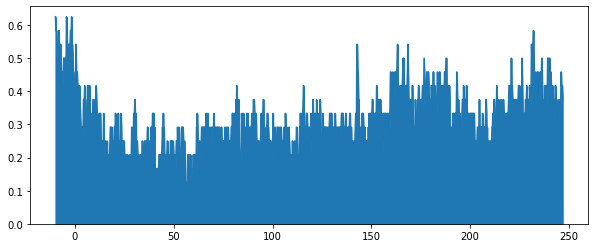

In [36]:
Data = SRP['emgc']['rms']['D']
FrameSize = 0.2 # second
HopSize = 0.2 # seconds
Thresh = 3
actType = 'UBound'
AC = aa.activityCount(Data,FrameSize,HopSize,Thresh,actType)
AC['Total'].plot.area(figsize=(10,4))
plt.show()

In [131]:
AllC = AC.drop(columns=['Total'])

FrameSize = 1
sF=np.round(1/pd.Series(AllC.index).diff().median())

frameN = int(FrameSize*sF)
AllC = AllC.append(pd.DataFrame(0,index=AllC.index[-1]+(np.arange(frameN)/sF), columns=AllC.columns))
AllC = AllC.append(pd.DataFrame(0,index=AllC.index[0]-((1+np.arange(frameN))/sF), columns=AllC.columns))
AllC = AllC.sort_index()
AllBlur = AllC.copy()
print(AllBlur.loc[:FrameSize])
for i in range(frameN-1):
    AllBlur += AllC.shift(i+1)
    print(AllBlur.loc[:FrameSize])
AllBlur.loc[:FrameSize]

Framed = AllBlur.loc[AC.index]
Framed[Framed>0] = 1
Framed['Total'] = Framed.sum(1)#/len(AllC.columns)
Framed

        0    1    2    3    4    5    6    7    8    9   ...   14   15   16  \
-10.9  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
-10.7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
-10.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
-10.3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
-10.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
-9.9   0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  ...  1.0  1.0  1.0   
-9.7   0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  ...  1.0  1.0  1.0   
-9.5   0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  ...  1.0  1.0  1.0   
-9.3   0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  ...  1.0  1.0  1.0   
-9.1   0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0  ...  1.0  0.0  1.0   
-8.9   0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  ...  1.0  0.0  1.0   
-8.7   0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,Total
-9.9,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,15.0
-9.7,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,15.0
-9.5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,15.0
-9.3,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,15.0
-9.1,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246.3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,13.0
246.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,13.0
246.7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,14.0
246.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,13.0


In [ ]:


FrameSize = 1

Framed = FramedSum(AllC,FrameSize)

In [144]:
def framedSum(AC,FrameSize):
    # AC is the output of actionCount, 
    # framesize is in the units of the AC index (time, s)
    # output is a counting of activity over frames of duration FrameSize. Basically convolution. 
    if 'Total' in AC.columns:
        AllC = AC.drop(columns=['Total'])
    else:
        AllC = AC.copy()
    sF=np.round(1/pd.Series(AllC.index).diff().median())
    frameN = int(FrameSize*sF)
    AllC = AllC.append(pd.DataFrame(0,index=AllC.index[-1]+((1+np.arange(frameN))/sF), columns=AllC.columns))
    AllC = AllC.append(pd.DataFrame(0,index=AllC.index[0]-((1+np.arange(frameN))/sF), columns=AllC.columns))
    AllC = AllC.sort_index()
    AllBlur = AllC.copy()
    for i in range(frameN-1):
        AllBlur += AllC.shift(i+1)
    Framed = AllBlur.loc[AC.index]
    Framed[Framed>0] = 1
    V = Framed.sum(1)/len(AllC.columns)
    return V

In [133]:
Framed['Total']

-9.9      15.0
-9.7      15.0
-9.5      15.0
-9.3      15.0
-9.1      15.0
          ... 
 246.3    13.0
 246.5    13.0
 246.7    14.0
 246.9    13.0
 246.9    11.0
Name: Total, Length: 1286, dtype: float64

In [134]:
FrameC

-9.9      15.0
-9.7      15.0
-9.5      15.0
-9.3      15.0
-9.1      15.0
          ... 
 246.3    13.0
 246.5    13.0
 246.7    14.0
 246.9    13.0
 246.9    11.0
Length: 1286, dtype: float64

<AxesSubplot:>

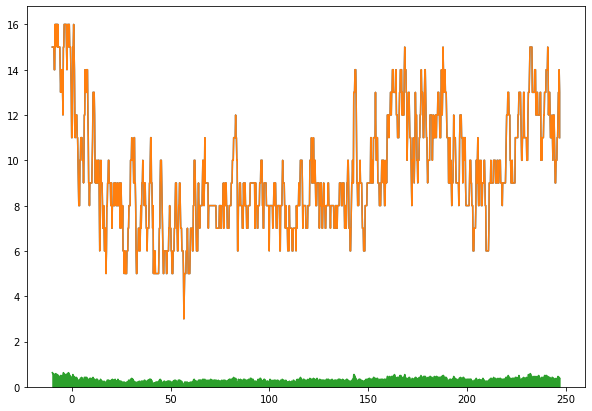

In [135]:
fig = plt.figure(figsize=(10,7))

Framed['Total'].plot()
AllC = AC.drop(columns=['Total'])
FrameC = framedSum(AC,FrameSize)
FrameC.plot()
AC['Total'].plot.area()

In [81]:
AllC = AC.drop(columns=['Total'])
AllC

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
-9.9,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
-9.7,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
-9.5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
-9.3,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
-9.1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
246.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
246.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
246.7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


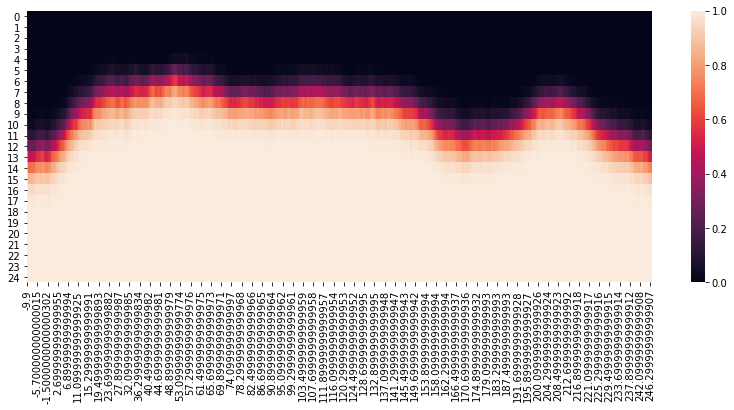

In [252]:
np.seterr(divide = 'ignore') 

AllC = AC.drop(columns=['Total'])
FrameSize = 1
N = 1000
ShuffleRange = 20 # seconds
sF=np.round(1/pd.Series(AllC.index).diff().median())
ShuffS = ShuffleRange*sF

Results = pd.DataFrame(index = AllC.index)
Results['Activity-levels'] = aa.framedSum(AC,FrameSize)
#ExpAl = aa.framedSum(AC,FrameSize)

S = AllC.shape
Np = S[1]
L = S[0]

# generate alternative distributions with shuffle range
AlternativeCoincs = pd.DataFrame(0, index=AllC.index, columns=np.arange(N))
for i in range(N):
    shifts = np.round(np.random.random_sample(Np)*ShuffS - ShuffS/2)
    # option = Loop
    SAllC = pd.DataFrame(index=AllC.index)
    for rn in range(S[1]):
        offs = int(shifts[rn])
        A = AllC[rn].shift(offs)
        if offs<0:
            A.iloc[offs:] = AllC[rn].iloc[:-offs].values
        else:
            if offs>0:
                A.iloc[:offs] = AllC[rn].iloc[-offs:].values
            else:
                A = AllC[rn]
        SAllC[rn]=A
    AlternativeCoincs[i] = aa.framedSum(SAllC,FrameSize) 
    #AG.plot()
    
# now evaluate distributions over complete excerpt
# TODO: trim the ends by half a shuffle range before evaluating statistics
aL = np.arange(Np+1)
TrueCounts = pd.DataFrame(0,index = aL,columns = ['Measured'])
meas = pd.Series(Results['Activity-levels']).value_counts()
TrueCounts.loc[meas.index,'Measured'] = meas.values/L

AltCounts = pd.DataFrame(0,index = aL,columns=np.arange(N))
for i in range(N): 
    meas = pd.Series(AlternativeCoincs[i]).value_counts()
    AltCounts.loc[meas.index,i] = meas.values/L

# empDist
cdistf = TrueCounts.cumsum()
ACdistf = AltCounts.cumsum()
meanAltCDistf = ACdistf.mean(1)
distanceTrueMean = (cdistf.add(-meanAltCDistf,0)**2).sum()**(0.5)
distanceMAlt = (ACdistf.add(-meanAltCDistf,0)**2).sum()**(0.5)
p = len(distanceMAlt[distanceMAlt>distanceTrueMean.values[0]])/N
    
    
#capture distibutions per frame for local activity stats
AltFrameCounts = pd.DataFrame(0,index=AlternativeCoincs.index,columns=aL)
Results['Local_p']= 0.5
for t in AlternativeCoincs.index:
    alt_lvls = AlternativeCoincs.loc[t].values
    actlvl_Counts = pd.DataFrame(0,index = aL,columns=[t])
    meas = pd.Series(alt_lvls).value_counts()
    actlvl_Counts.loc[meas.index,t] = meas.values
    AltFrameCounts.loc[t] = actlvl_Counts.transpose().values.cumsum()/N
    Results.loc[t,'Local_p'] = AltFrameCounts.loc[t,Results.loc[t,'Activity-levels']]
AltFrameCounts = AltFrameCounts

pVal = Results['Local_p']
pVal[pVal<10.0**(-5)]= 10.0**(-5)
surp = np.log10((1-pVal)/pVal)
surp[surp>3] = 3
surp[surp<-3] = -3
Results['Surprise'] = surp

fig = plt.figure(figsize=(14,5))
ax = plt.gca()
sns.heatmap(AltFrameCounts.transpose(),ax=ax)#,cbar=False,vmin=0, vmax=4)#, cmap="YlGnBu")
#(AC['Total']*Np).plot(ax=ax)
plt.show()

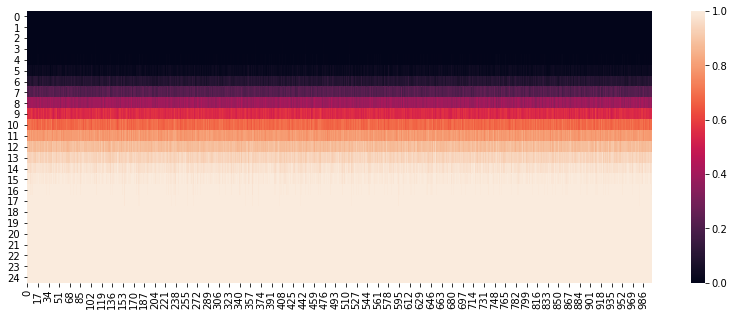

In [257]:
fig = plt.figure(figsize=(14,5))
ax = plt.gca()
sns.heatmap(AltCounts.cumsum(),ax=ax)#,cbar=False,vmin=0, vmax=4)#, cmap="YlGnBu")
#(AC['Total']*Np).plot(ax=ax)
plt.show()

In [288]:
# empDist
cdistf = TrueCounts.cumsum()
ACdistf = AltCounts.cumsum()
meanAltCDistf = ACdistf.mean(1)
distanceTrueMean = (cdistf.add(-meanAltCDistf,0)**2).sum()**(0.5)
distanceTrueMean
distanceMAlt = (ACdistf.add(-meanAltCDistf,0)**2).sum()**(0.5)
p = len(distanceMAlt[distanceMAlt>distanceTrueMean.values[0]])/N

0.039

In [284]:
distanceTrueMean.values[0]

0.06680704321083358

In [287]:
distanceMAlt>distanceTrueMean.values[0]

2    False
3    False
4    False
5    False
dtype: bool

In [247]:
Results

,Activity-levels,Local_p,Surprise
-9.9,15.0,0.999,-2.999565
-9.7,15.0,0.988,-1.915576
-9.5,15.0,0.969,-1.494962
-9.3,15.0,0.933,-1.143807
-9.1,15.0,0.889,-0.903579
...,...,...,...
246.1,12.0,0.304,0.359736
246.3,13.0,0.514,-0.024327
246.5,13.0,0.498,0.003474
246.7,14.0,0.721,-0.412331


In [298]:
Iter = 1000
ShuffleRange = 20 # seconds
Framesize = 1 # seconds
AllC = AC.drop(columns=['Total'])
a=aa.localActivityTest(AllC,FrameSize,ShuffleRange,Iter)
a

{'pvalue': 0.046,
 'MeasuredResults':         Activity-levels  Local_p  Surprise
 -9.9               15.0    0.996 -2.396199
 -9.7               15.0    0.986 -1.847749
 -9.5               15.0    0.964 -1.427775
 -9.3               15.0    0.928 -1.110215
 -9.1               15.0    0.888 -0.899195
 ...                 ...      ...       ...
  246.1             12.0    0.304  0.359736
  246.3             13.0    0.533 -0.057410
  246.5             13.0    0.526 -0.045207
  246.7             14.0    0.742 -0.458784
  246.9             13.0    0.511 -0.019112
 
 [1285 rows x 3 columns],
 'Models':          0     1     2     3     4     5     6     7     8     9    ...   990  \
 -9.9     8.0  11.0   8.0  12.0  11.0  12.0   9.0  12.0  14.0  10.0  ...   9.0   
 -9.7     9.0  11.0  11.0  14.0  12.0  13.0   9.0  12.0  14.0  10.0  ...   9.0   
 -9.5    10.0  13.0  12.0  14.0  12.0  14.0   9.0  12.0  14.0  10.0  ...  10.0   
 -9.3    10.0  13.0  13.0  15.0  12.0  14.0  11.0  14.0  14.0  10.0  

In [303]:
Results = a['MeasuredResults']

aL = np.arange(Np+1)
TrueCounts = pd.DataFrame(0,index = aL,columns = ['Measured'])
meas = pd.Series(Results['Activity-levels']).value_counts()
TrueCounts.loc[meas.index,'Measured'] = meas.values/L
TrueCounts['cdf'] = TrueCounts.cumsum()

T = Results['Activity-levels'].copy()
for index, row in TrueCounts.iterrows():
    T[T==index] = row['cdf']
T

-9.9      0.986770
-9.7      0.986770
-9.5      0.986770
-9.3      0.986770
-9.1      0.986770
            ...   
 246.1    0.861479
 246.3    0.926070
 246.5    0.926070
 246.7    0.961868
 246.9    0.926070
Name: Activity-levels, Length: 1285, dtype: float64

In [306]:
D=activityLevelRanks(Results['Activity-levels'])
D

-9.9      0.986770
-9.7      0.986770
-9.5      0.986770
-9.3      0.986770
-9.1      0.986770
            ...   
 246.1    0.861479
 246.3    0.926070
 246.5    0.926070
 246.7    0.961868
 246.9    0.926070
Name: Activity-levels, Length: 1285, dtype: float64

In [305]:
def activityLevelRanks(AC):
    # take in activity level time series and convert to rank values from cdf
    Np = AC.max()
    aL = np.arange(Np+1)
    TrueCounts = pd.DataFrame(0,index = aL,columns = ['Measured'])
    meas = pd.Series(AC).value_counts()
    TrueCounts.loc[meas.index,'Measured'] = meas.values/L
    TrueCounts['cdf'] = TrueCounts.cumsum()

    T = AC.copy()
    for index, row in TrueCounts.iterrows():
        T[T==index] = row['cdf']
    return T


In [291]:
def localActivityTest(AllC,FrameSize,ShuffleRange,Iter):
    # function to evaluate nonparametricly the distribution of coincidences of events in AllC
    # measured in frames FrameSize, with alignment shuffling range of ShufflrRange over Iter iterations
    # TODO seed the random number generator
    # TODO options defines strategy for ends in the shuffling process. Default: Loop
    # TODO analyse over restricted range (exclude half shuffle range from either end) to avoid loop deviations
    # TODO evaluate distributions on local rank rather than absolute counts
    #function uses framedSum and score_c and AllC is optimally set up by actionCount, with Total removed

    sF=np.round(1/pd.Series(AllC.index).diff().median()) # assumes sample rate is >=1 Hz
    S = AllC.shape
    Np = S[1] # number of responses in AllC
    L = S[0] # number of samples in which activity has been assessed
    ShuffS = ShuffleRange*sF # the number of samples overwhich shuffling is performed
    Results = pd.DataFrame(index = AllC.index)
    Results['Activity-levels'] = aa.framedSum(AllC,FrameSize) 

    # generate alternative distributions with shuffle range
    AlternativeCoincs = pd.DataFrame(0, index=AllC.index, columns=np.arange(Iter))
    for i in range(Iter):
        shifts = np.round(np.random.random_sample(Np)*ShuffS - ShuffS/2)
        # option = Loop
        SAllC = pd.DataFrame(index=AllC.index)
        for rn in range(S[1]):
            offs = int(shifts[rn])
            A = AllC[rn].shift(offs)
            if offs<0:
                A.iloc[offs:] = AllC[rn].iloc[:-offs].values
            else:
                if offs>0:
                    A.iloc[:offs] = AllC[rn].iloc[-offs:].values
                else:
                    A = AllC[rn]
            SAllC[rn]=A
        AlternativeCoincs[i] = aa.framedSum(SAllC,FrameSize) 

    # now evaluate distributions over complete excerpt
    # TODO: trim the ends by half a shuffle range before evaluating statistics
    aL = np.arange(Np+1)
    TrueCounts = pd.DataFrame(0,index = aL,columns = ['Measured'])
    meas = pd.Series(Results['Activity-levels']).value_counts()
    TrueCounts.loc[meas.index,'Measured'] = meas.values/L

    AltCounts = pd.DataFrame(0,index = aL,columns=np.arange(Iter))
    for i in range(Iter): 
        meas = pd.Series(AlternativeCoincs[i]).value_counts()
        AltCounts.loc[meas.index,i] = meas.values/L

    # empDist
    cdistf = TrueCounts.cumsum()
    ACdistf = AltCounts.cumsum()
    meanAltCDistf = ACdistf.mean(1)
    distanceTrueMean = (cdistf.add(-meanAltCDistf,0)**2).sum()**(0.5)
    distanceMAlt = (ACdistf.add(-meanAltCDistf,0)**2).sum()**(0.5)
    p = len(distanceMAlt[distanceMAlt>distanceTrueMean.values[0]])/Iter
    CS = aa.score_C(p)

    #capture distibutions per frame for local activity stats
    AltFrameCounts = pd.DataFrame(0,index=AlternativeCoincs.index,columns=aL)
    Results['Local_p']= 0.5
    for t in AlternativeCoincs.index:
        alt_lvls = AlternativeCoincs.loc[t].values
        actlvl_Counts = pd.DataFrame(0,index = aL,columns=[t])
        meas = pd.Series(alt_lvls).value_counts()
        actlvl_Counts.loc[meas.index,t] = meas.values
        AltFrameCounts.loc[t] = actlvl_Counts.transpose().values.cumsum()/Iter
        Results.loc[t,'Local_p'] = AltFrameCounts.loc[t,Results.loc[t,'Activity-levels']]
    AltFrameCounts = AltFrameCounts

    pVal = Results['Local_p']
    pVal[pVal<10.0**(-5)]= 10.0**(-5)
    surp = np.log10((1-pVal)/pVal)
    surp[surp>3] = 3
    surp[surp<-3] = -3
    Results['Surprise'] = surp
        
#    [pVal,Coinc,CoincRank,CoincSurprise,AlternativeCoincs,AltP,altpVal,NPCscore,altNPCscore]
    stest = {'pvalue':p,'MeasuredResults':Results,'Models':AlternativeCoincs,'CoordScore':CS}
    return stest

def localActivityRankTest(AllC,FrameSize,ShuffleRange,Iter):
    # function to evaluate nonparametricly the distribution of coincidences of events in AllC
    # measured in frames FrameSize, with alignment shuffling range of ShufflrRange over Iter iterations
    # TODO seed the random number generator
    # TODO options defines strategy for ends in the shuffling process. Default: Loop
    # TODO analyse over restricted range (exclude half shuffle range from either end) to avoid loop deviations
    # TODO evaluate distributions on local rank rather than absolute counts
    #function uses framedSum and score_c and AllC is optimally set up by actionCount, with Total removed

    sF=np.round(1/pd.Series(AllC.index).diff().median()) # assumes sample rate is >=1 Hz
    S = AllC.shape
    Np = S[1] # number of responses in AllC
    L = S[0] # number of samples in which activity has been assessed
    ShuffS = ShuffleRange*sF # the number of samples overwhich shuffling is performed
    Results = pd.DataFrame(index = AllC.index)
    Results['Activity-levels'] = aa.framedSum(AllC,FrameSize) 
    Results['Ranks'] = aa.activityLevelRanks(Results['Activity-levels'])
    
    # generate alternative distributions with shuffle range
    AlternativeCoincs = pd.DataFrame(0, index=AllC.index, columns=np.arange(Iter))
    AlternativeRanks =AlternativeCoincs.copy()
    for i in range(Iter):
        shifts = np.round(np.random.random_sample(Np)*ShuffS - ShuffS/2)
        # option = Loop
        SAllC = pd.DataFrame(index=AllC.index)
        for rn in range(S[1]):
            offs = int(shifts[rn])
            A = AllC[rn].shift(offs)
            if offs<0:
                A.iloc[offs:] = AllC[rn].iloc[:-offs].values
            else:
                if offs>0:
                    A.iloc[:offs] = AllC[rn].iloc[-offs:].values
                else:
                    A = AllC[rn]
            SAllC[rn]=A
        AlternativeCoincs[i] = aa.framedSum(SAllC,FrameSize) 
        AlternativeRanks[i] = aa.activityLevelRanks(AlternativeCoincs[i])

    # now evaluate distributions over complete excerpt
    # TODO: trim the ends by half a shuffle range before evaluating statistics
    aL = np.arange(Np+1)
    TrueCounts = pd.DataFrame(0,index = aL,columns = ['Measured'])
    meas = pd.Series(Results['Activity-levels']).value_counts()
    TrueCounts.loc[meas.index,'Measured'] = meas.values/L

    AltCounts = pd.DataFrame(0,index = aL,columns=np.arange(Iter))
    for i in range(Iter): 
        meas = pd.Series(AlternativeCoincs[i]).value_counts()
        AltCounts.loc[meas.index,i] = meas.values/L
        
    AltRanks = pd.DataFrame(0,index = aL,columns=np.arange(Iter))
    for i in range(Iter): 
        meas = pd.Series(AlternativeCoincs[i]).value_counts()
        AltRanks.loc[meas.index,i] = meas.values/L

    # empDist
    cdistf = TrueCounts.cumsum()
    ACdistf = AltCounts.cumsum()
    meanAltCDistf = ACdistf.mean(1)
    distanceTrueMean = (cdistf.add(-meanAltCDistf,0)**2).sum()**(0.5)
    distanceMAlt = (ACdistf.add(-meanAltCDistf,0)**2).sum()**(0.5)
    p = len(distanceMAlt[distanceMAlt>distanceTrueMean.values[0]])/Iter
    CS = aa.score_C(p)

    #capture distibutions per frame for local activity stats
    AltFrameCounts = pd.DataFrame(0,index=AlternativeCoincs.index,columns=aL)
    Results['Local_p']= 0.5
    for t in AlternativeCoincs.index:
        alt_lvls = AlternativeCoincs.loc[t].values
        actlvl_Counts = pd.DataFrame(0,index = aL,columns=[t])
        meas = pd.Series(alt_lvls).value_counts()
        actlvl_Counts.loc[meas.index,t] = meas.values
        AltFrameCounts.loc[t] = actlvl_Counts.transpose().values.cumsum()/Iter
        Results.loc[t,'Local_p'] = AltFrameCounts.loc[t,Results.loc[t,'Activity-levels']]
    AltFrameCounts = AltFrameCounts

    pVal = Results['Local_p']
    pVal[pVal<10.0**(-5)]= 10.0**(-5)
    surp = np.log10((1-pVal)/pVal)
    surp[surp>3] = 3
    surp[surp<-3] = -3
    Results['Surprise'] = surp
        
#    [pVal,Coinc,CoincRank,CoincSurprise,AlternativeCoincs,AltP,altpVal,NPCscore,altNPCscore]
    stest = {'pvalue':p,'MeasuredResults':Results,'Models':AlternativeCoincs,'CoordScore':CS}
    return stest